In [1]:
!pip install gensim --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install --upgrade numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 77.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.2 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.2 which is incompatible.


In [ ]:
pip install transformers


In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## **데이터셋**

In [6]:
import pandas as pd
import numpy as np

In [4]:
df=pd.read_csv('/content/gdrive/MyDrive/train.csv')

In [6]:
df.head()

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...


In [ ]:
{k: v for k, v in enumerate(df.discourse_type.unique())}

{0: 'Lead',
 1: 'Evidence',
 2: 'Claim',
 3: 'Concluding Statement',
 4: 'Counterclaim',
 5: 'Rebuttal',
 6: 'Position'}

In [5]:
df.shape

(144293, 8)

In [ ]:
df_raw=pd.read_csv('/content/gdrive/MyDrive/train.csv')

In [8]:
df

,id,discourse_text,discourse_type
0,423A1CA112E2,modern humans today are always on their phone....,Lead
1,423A1CA112E2,they are some really bad consequences when stu...,Position
2,423A1CA112E2,some certain areas in the united states ban ph...,Evidence
3,423A1CA112E2,"when people have phones, they know about certa...",Evidence
4,423A1CA112E2,driving is one of the way how to get around. p...,Claim
...,...,...,...
144288,4C471936CD75,if i'm not sure what college i want to attend...,Evidence
144289,4C471936CD75,seeking multiple opinions before making a har...,Evidence
144290,4C471936CD75,it is better to seek multiple opinions instead...,Position
144291,4C471936CD75,the impact of asking people to help you make a...,Evidence


In [ ]:
df_1=df.iloc[:int(len(df)/2)]

In [ ]:
df_2=df.iloc[int(len(df)/2):]

In [ ]:
df=df_2

In [4]:
import re
import string

In [ ]:
#def split_by_new(text):
    #split_marks = '[.?!]'
    #if re.search(f'{split_marks}$', text):
    #    return re.sub(f'{split_marks}$', '/', text)
    #else:
    #    return text + '/'

In [ ]:
#def remove_weird_characters(text):
    #return re.sub(r'[^\x00-\x7F]+','', text)

## **전처리**

In [7]:
df=df[['id', 'discourse_text', 'discourse_type']]
df['discourse_text']=df['discourse_text'].str.lower()

In [4]:
def unchar(txts):
  punctuation_marks = set(string.punctuation)
  lst_2=[]

  for doc in txts:
    lst=[char for char in doc if char in punctuation_marks or char.isspace()]
    for char in lst:
      lst_2.append(char)

  return set(lst_2)-set(["'"])

In [5]:
def preprocessing(df):
  useless=unchar(df['discourse_text'])

  strin=""
  for i in useless:
    strin+=i
  intab=strin
  outtab=len(strin)*' '
  trantab = str.maketrans(intab, outtab) #글자가 아닌 것들을 ' '으로 치환

  df['discourse_text']=df['discourse_text'].str.translate(trantab) #글자가 아닌 것들을 ' '으로 치환
  df['discourse_text']=df['discourse_text'].map(lambda x: x.replace("  ", " ")) #'  '을 ' '으로 치환
  df['discourse_text']=df['discourse_text'].map(lambda x: re.sub(r'[^\x00-\x7F]+','', x)) #df['discourse_text'][36002]
  
  for i, doc in enumerate(df['discourse_text']):
    df['discourse_text'][i]=doc.strip() #문장 앞 뒤 빈칸 제거
    df['discourse_text'][i]= 'SOS' + ' ' + doc + ' ' + 'EOS' #시작토큰-'SOS', 종료토큰-'EOS'
  
  return df


## **토큰화**

In [5]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_sm")

tokenizer = Tokenizer(nlp.vocab)

In [16]:
def tokenize(sentence):
  tokens=nlp(sentence)
  lst=[token.text if token.text in ['SOS', 'EOS'] else token.lemma_ if not token.pos_ in ['ADP', 'AUX', 'DET', 'PRON'] else 0 for token in tokens]
  lst=[re.sub(r'[ ]', '', x) for x in lst if isinstance(x, str)]
  return lst
  
def remov_space(tok_lst):
  for token in tok_lst:
    if len(token)<=1:
      tok_lst.remove(token)
  return tok_lst

In [ ]:
df['discourse_text_tokens']=df['discourse_text'].map(lambda x: tokenize(x))
df['discourse_text_tokens']=df['discourse_text_tokens'].map(lambda x: remov_space(x))

In [ ]:
df.to_csv('tokenized_2.csv', index=False)

In [ ]:
df_1=pd.read_csv('tokenized_1.csv')
df_2=pd.read_csv('tokenized_2.csv')

In [ ]:
df=pd.concat([df_1, df_2], axis=0).reset_index(drop=True)

In [30]:
df=pd.read_csv('tokenized_fin.csv')

In [9]:
df=pd.read_csv('/content/tokenzed_fin2.csv')

In [ ]:
df

In [11]:
import ast

In [31]:
df['discourse_text_tokens']=df['discourse_text_tokens'].map(lambda x: ast.literal_eval(x))

In [20]:
import matplotlib.pyplot as plt

In [13]:
mean_tot=np.mean([len(tokens) for tokens in df['discourse_text_tokens']])
mean_lead=np.mean([len(tokens) for tokens in df[df['discourse_type']=='Lead']['discourse_text_tokens']])
mean_evi=np.mean([len(tokens) for tokens in df[df['discourse_type']=='Evidence']['discourse_text_tokens']])
mean_clm=np.mean([len(tokens) for tokens in df[df['discourse_type']=='Claim']['discourse_text_tokens']])
mean_conc=np.mean([len(tokens) for tokens in df[df['discourse_type']=='Concluding Statement']['discourse_text_tokens']])
mean_cnt=np.mean([len(tokens) for tokens in df[df['discourse_type']=='Counterclaim']['discourse_text_tokens']])
mean_reb=np.mean([len(tokens) for tokens in df[df['discourse_type']=='Rebuttal']['discourse_text_tokens']])
mean_pos=np.mean([len(tokens) for tokens in df[df['discourse_type']=='Position']['discourse_text_tokens']])

## **토큰화된 데이터 분석**

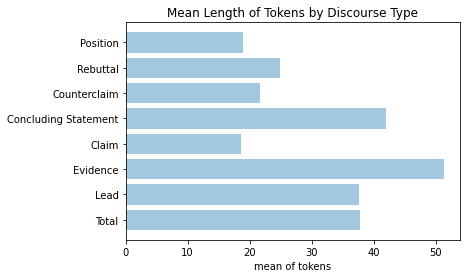

In [14]:
means = [mean_tot, mean_lead, mean_evi, mean_clm, mean_conc, mean_cnt, mean_reb, mean_pos]
labels = ['Total', 'Lead', 'Evidence', 'Claim', 'Concluding Statement', 'Counterclaim', 'Rebuttal', 'Position']

x = range(len(labels))

plt.title("Mean Length of Tokens by Discourse Type")
plt.barh(x, means, alpha=0.4)
plt.yticks(x, labels)
plt.xlabel('mean of token length')
plt.show();


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


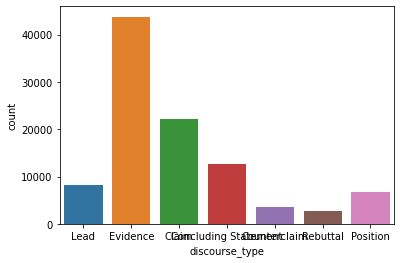

In [15]:
import seaborn as sns
sns.countplot(df['discourse_type'])

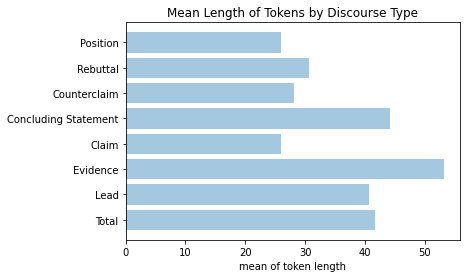

In [21]:
means = [mean_tot, mean_lead, mean_evi, mean_clm, mean_conc, mean_cnt, mean_reb, mean_pos]
labels = ['Total', 'Lead', 'Evidence', 'Claim', 'Concluding Statement', 'Counterclaim', 'Rebuttal', 'Position']

x = range(len(labels))

plt.title("Mean Length of Tokens by Discourse Type")
plt.barh(x, means, alpha=0.4)
plt.yticks(x, labels)
plt.xlabel('mean of token length')
plt.show();

In [ ]:
def preprocessing_2(df):
  for i, tokens in enumerate(df['discourse_text_tokens']):
    for token in tokens:
      if word_counts[token]<3: #빈도 수가 1, 2인 토큰 제거
        df['discourse_text_tokens'][i].remove(token)
        
  for i, tokens in enumerate(df['discourse_text_tokens']): #문장 길이(토큰 수)가 25미만인 문장의 토큰을 불용어까지 포함시켜 문장 길이를 늘림.
    if len(tokens) < 25:
      lst = [token.text if token.text in ['SOS', 'EOS'] else token.lemma_ for token in nlp(df['discourse_text'][i])]
      lst=[re.sub(r'[ ]', '', x) for x in lst]
      df['discourse_text_tokens'][i] = remov_space(lst)
  
  return df

In [ ]:
def preprocessing_2(df):
  for i, tokens in enumerate(df['discourse_text_tokens']):
    for token in tokens:
      if word_counts[token]<3: #빈도 수가 1, 2인 토큰 제거
        df['discourse_text_tokens'][i].remove(token)
        
  for i, tokens in enumerate(df['discourse_text_tokens']): #문장 길이(토큰 수)가 25미만인 문장 제거
    if len(tokens) < 25:
      df.drop(index=i, inplace=True)
  
  return df

In [ ]:
from collections import Counter
word_counts=Counter()

df['discourse_text_tokens'].apply(word_counts.update)

0        None
1        None
2        None
3        None
4        None
         ... 
99611    None
99612    None
99613    None
99614    None
99615    None
Name: discourse_text_tokens, Length: 99616, dtype: object

In [17]:
for i, tokens in enumerate(df['discourse_text_tokens']): #문장 길이(토큰 수)가 25미만인 문장의 토큰을 불용어까지 포함시켜 문장 길이를 늘림.
  if len(tokens) < 25:
    lst = [token.text if token.text in ['SOS', 'EOS'] else token.lemma_ for token in nlp(df['discourse_text'][i])]
    lst=[re.sub(r'[ ]', '', x) for x in lst]
    df['discourse_text_tokens'][i] = remov_space(lst)

In [32]:
for i, tokens in enumerate(df['discourse_text_tokens']): #문장 길이(토큰 수)가 25미만인 문장 제거
  if len(tokens) < 25:
    df.drop(index=i, inplace=True)

In [33]:
df.to_csv('tokenzed_fin2.csv', index=False)

In [34]:
df.reset_index(drop=True, inplace=True)

In [35]:
df

,id,discourse_text,discourse_type,discourse_text_tokens
0,423A1CA112E2,SOS modern humans today are always on their ph...,Lead,"[SOS, modern, human, today, always, phone, alw..."
1,423A1CA112E2,SOS when people have phones they know about ce...,Evidence,"[SOS, when, people, have, phone, know, certain..."
2,423A1CA112E2,SOS that's why there's a thing that's called n...,Evidence,"[SOS, why, be, thing, call, texting, while, dr..."
3,423A1CA112E2,SOS sometimes on the news there is either an a...,Evidence,"[SOS, sometimes, news, be, either, accident, o..."
4,423A1CA112E2,SOS if you go through a problem and you can't ...,Evidence,"[SOS, if, go, problem, and, not, find, help, a..."
...,...,...,...,...
57627,4C471936CD75,SOS if the president thinks that this is the b...,Evidence,"[SOS, if, president, think, that, good, time, ..."
57628,4C471936CD75,SOS if i'm not sure what college i want to at...,Evidence,"[SOS, if, not, sure, college, want, to, attend..."
57629,4C471936CD75,SOS seeking multiple opinions before making a...,Evidence,"[SOS, seek, multiple, opinion, make, hard, dec..."
57630,4C471936CD75,SOS the impact of asking people to help you ma...,Evidence,"[SOS, impact, ask, people, to, help, make, dec..."


In [ ]:
preprocessing_2(df)

In [2]:
import gensim
import gensim.downloader as api

In [3]:
from gensim.models import Word2Vec
from gensim.models import FastText
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

## **인덱싱 및 임베딩벡터 제작**

In [36]:
from sklearn.model_selection import train_test_split

X=df['discourse_text_tokens']
y=df['discourse_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

sents_in=[doc for doc in X]
sents_in_train=[doc for doc in X_train]
sents_in_test=[doc for doc in X_test]

In [37]:
ft_model = FastText(X, vector_size=300, window=5, min_count=0, workers=4, sg=1) #원래 100, fast text로 만든 임베딩 벡터

tokenizer_k = Tokenizer()
tokenizer_k.fit_on_texts(sents_in)
vocab_size=len(tokenizer_k.word_index)+1

X_train_encoded = tokenizer_k.texts_to_sequences(X_train)
X_test_encoded = tokenizer_k.texts_to_sequences(X_test)

num_to_label = {k: v for k, v in enumerate(df.discourse_type.unique())}
label_to_num = {v: k for k, v in enumerate(df.discourse_type.unique())}

y_train=y_train.map(label_to_num)
y_train=to_categorical(y_train)
y_test=y_test.map(label_to_num)
y_test=to_categorical(y_test)

max_len = max([len(i) for i in X])
X_train_input=pad_sequences(X_train_encoded, maxlen=max_len, padding='post')
X_test_input=pad_sequences(X_test_encoded, maxlen=max_len, padding='post')

pad_row = np.array([0]*300)

embedding_matrix = np.vstack((pad_row, ft_model.wv.vectors)) #for pad sequence which is labeled 0

In [38]:
vocab_size==embedding_matrix.shape[0]

True

In [27]:
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [29]:
embedding_matrix = np.zeros((vocab_size, 300))

def get_vector(word):
    if word in wv:
        return wv[word]
    else:
        return None

for word, i in tokenizer_k.word_index.items():
    temp = get_vector(word)
    if temp is not None:
        embedding_matrix[i] = temp
        
embedding_matrix.shape #word2vec에 있는 pre-trained 임베딩벡터를 이용해 제작한 임베딩벡터

(20053, 300)

## **딥러닝 모델 제작**

In [ ]:

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [39]:
hidden_units = 256
num_classes = 7

model = Sequential()
model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))


In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 464, 300)          6015900   
                                                                 
 dense (Dense)               (None, 464, 256)          77056     
                                                                 
 dense_1 (Dense)             (None, 464, 256)          65792     
                                                                 
 lstm (LSTM)                 (None, 256)               525312    
                                                                 
 dense_2 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 6,685,859
Trainable params: 669,959
Non-trainable params: 6,015,900
_________________________________________________________________


In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train_input, y_train, batch_size=32, epochs=15,  validation_data=(X_test_input, y_test))

Epoch 1/15
2491/2491 [==============================] - 83s 31ms/step - loss: 1.5659 - acc: 0.4405 - val_loss: 1.5739 - val_acc: 0.4341
Epoch 2/15
2491/2491 [==============================] - 77s 31ms/step - loss: 1.5635 - acc: 0.4405 - val_loss: 1.5691 - val_acc: 0.4341
Epoch 3/15
2491/2491 [==============================] - 77s 31ms/step - loss: 1.5630 - acc: 0.4405 - val_loss: 1.5686 - val_acc: 0.4341
Epoch 4/15
2491/2491 [==============================] - 77s 31ms/step - loss: 1.5629 - acc: 0.4405 - val_loss: 1.5682 - val_acc: 0.4341
Epoch 5/15
 237/2491 [=>............................] - ETA: 1:03 - loss: 1.5846 - acc: 0.4288

KeyboardInterrupt: ignored

In [40]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train_input, y_train, batch_size=32, epochs=15,  validation_data=(X_test_input, y_test))

Epoch 1/15
1441/1441 [==============================] - 47s 32ms/step - loss: 1.1948 - acc: 0.6272 - val_loss: 1.1879 - val_acc: 0.6265
Epoch 2/15
1441/1441 [==============================] - 44s 31ms/step - loss: 1.1879 - acc: 0.6275 - val_loss: 1.1859 - val_acc: 0.6265
Epoch 3/15
1441/1441 [==============================] - 44s 31ms/step - loss: 1.1869 - acc: 0.6275 - val_loss: 1.1877 - val_acc: 0.6265
Epoch 4/15
1441/1441 [==============================] - 44s 31ms/step - loss: 1.1867 - acc: 0.6275 - val_loss: 1.1879 - val_acc: 0.6265
Epoch 5/15
1441/1441 [==============================] - 44s 31ms/step - loss: 1.1867 - acc: 0.6275 - val_loss: 1.1875 - val_acc: 0.6265
Epoch 6/15
1441/1441 [==============================] - 45s 31ms/step - loss: 1.1867 - acc: 0.6275 - val_loss: 1.1882 - val_acc: 0.6265
Epoch 7/15
 109/1441 [=>............................] - ETA: 36s - loss: 1.1795 - acc: 0.6316

KeyboardInterrupt: ignored

In [ ]:
df_concat_within_id = df.groupby('id')['discourse_text'].apply(' '.join).reset_index()

In [ ]:
df_concat_within_id

,id,discourse_text
0,0000D23A521A,"Some people belive that the so called ""face"" o..."
1,00066EA9880D,Driverless cars are exaclty what you would exp...
2,000E6DE9E817,I am arguing against the policy change even t...
3,001552828BD0,Would you be able to give your car up? Having ...
4,0016926B079C,I think that students would benefit from learn...
...,...,...
15589,FFF1442D6698,"Every student looks forward to summer break, i..."
15590,FFF1ED4F8544,Many citizens argue that the Electoral college...
15591,FFF868E06176,"Every summer break, students are given project..."
15592,FFFD0AF13501,they get to see tons of awesome landmarks. If...


In [ ]:
https://plan0a-0z-entering-security.tistory.com/48

In [ ]:
def calc_distance(a,b):
    '''레벤슈타인 거리 계산하기'''
    if a==b : return 0
    a_len=len(a)
    b_len=len(b)
    if a=="" : return b_len 
    if b=="" : return a_len

    #2차원 배열(a_len+1, b_len+1)준비하기 --(#1)
    matrix= [ []for i in range(a_len+1)] #a길이+1 만큼의 크기의 배열준비
    for i in range(a_len+1) :
        matrix[i] = [0 for j in range(b_len+1)] #0으로 초기화(2차원배열)    
   
    #0일때 초기값을 설정 (#2)
    for i in range(a_len+1):
        matrix[i][0]=i   
    for j in range(b_len+1):
        matrix[0][j]=j
    
    #표 채우기 --(#3)
    for i in range(1,a_len+1):
        ac=a[i-1]  #a의 첫번째 글자(=[0]) 부터 시작
        for j in range(1, b_len+1):
            bc=b[j-1] #b의 첫번째글자(=[0]) 부터 시작
            cost=0 if (ac ==bc) else 1 #a[i-1]과 b[j-1] 이 같다면 비용(cost)은 0. 같지 않으면 1
            matrix[i][j] = min([  #min 함수 : 최소값을 돌려줌; 
            #a의 i번째까지의 문자와 b의 j번째까지의 문자를 비교해서, 삽입/제거/변경 비용 중 최소값으로 표를 채운다.
                matrix[i-1][j] + 1,     # 문자 삽입
                matrix[i][j-1] + 1,     # 문자 제거
                matrix[i-1][j-1] + cost # 문자 변경
            ])
    return matrix[a_len][b_len] #최종적으로는, 표의 오른쪽 아래에 있는 값이 최소거리(레벤슈타인 거리)가 된다.
    #ㄴ함수 calc_distance 끝


#"가나다라"와 "가마바라"의 거리 --(#4)
print("'가나다라'와 '가마바라'의 거리: ",end='')
print(calc_distance("가나다라", "가마바라"))

'가나다라'와 '가마바라'의 거리: 2
